In [19]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

import shap

In [21]:
# plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [22]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [23]:
# Config
SAVE_SUB = True
SAVE_SUB_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/sub_20230225")
SUB_FILE_NAME = "val8-2"

# データ読み込み

In [24]:
train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/submit_example.csv")

# 特徴抽出後のデータ
umap_basic_train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_train.pkl")
umap_basic_test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_test.pkl")
train_sentinel = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_train_sentinel_minmaxDiff.pkl")
test_sentinel = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_test_sentinel_minmaxDiff.pkl")
train_landsat_2000to2020 = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_train_landsat_2000to2020.pkl")
test_landsat_2000to2020 = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_test_landsat_2000to2020.pkl")
train_landsat_minmax = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_train_landsat_minmax.pkl")
test_landsat_minmax = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_test_landsat_minmax.pkl")

train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13


In [25]:
sub.head(2)

,0,0.47
0,1,0.68
1,2,0.25


# 前処理

## 対数変換

In [26]:
train[f"log_cover"] = np.log1p(train["cover"])

## 特徴抽出後のデータを結合

In [27]:
print(train.shape)
print(train_landsat_minmax.shape)
print(test.shape)
print(test_landsat_minmax.shape)
train_landsat_minmax.head(2)

(14140, 3465)
(14140, 50)
(4039, 3463)
(4039, 50)


,MINMAX_MVI,MINMAX_Chlred_edge,MINMAX_NLI,MINMAX_IF,MINMAX_GEMI,MINMAX_Chlgreen,MINMAX_CVI,MINMAX_DSWI_5,MINMAX_TSAVI,MINMAX_PSNDc2,...,MINMAX_EVI,MINMAX_GVMI,MINMAX_RDVI,MINMAX_PPR,MINMAX_SIPI2,MINMAX_Cigreen,MINMAX_D678_500,MINMAX_DVIMSS,MINMAX_Green,MINMAX_Alteration
0,-0.498732,-0.031920,1.075848,1.225176,0.018427,0.065996,0.91124,0.839658,1.035656,1.000000,...,0.558870,0.176156,0.345818,1.035576,0.350692,0.960665,-0.223362,1.000000,1.052035,3.30233
1,0.698608,1.080161,-0.089137,-1.235533,0.525556,1.083810,-0.57457,-0.393703,-0.195017,-0.575291,...,2.011747,0.262679,-0.418989,-0.841783,0.968533,-0.482458,-0.112053,-1.535718,-0.357916,-0.12575


In [28]:
train = train.join([
    umap_basic_train,
    train_sentinel,
    train_landsat_minmax,
    train_landsat_2000to2020,
])
test = test.join([
    umap_basic_test,
    test_sentinel,
    test_landsat_minmax,
    test_landsat_2000to2020,
])
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MAX_D678_500__median,MIN_Fe3__median,MAX_Chlgreen__median,MED_CI__mean,MED_Cigreen__mean,MED_NormG__mean,MAX_Alteration__median,MAX_CVI__median,MED_GVMI__mean,MED_H__mean
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,-34.231005,0.464154,5.596622,-2.412849,-0.765163,0.578941,4.325302,0.177657,0.931891,1.465471
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,-26.482969,0.589454,5.961674,-0.998966,-0.499455,0.485871,6.066018,0.463270,0.965646,1.502791


## ダウンサンプリング

In [29]:
print("●trainの行数")
print(len(train))
print("●trainの行数 (2019年8～10月のみ)")
print(len(train.loc[((train["year"]==2019)&(train["month"].isin([8, 9, 10])))]))

●trainの行数
14140
●trainの行数 (2019年8～10月のみ)
4069


In [30]:
downsampling_rate = 0.5
train["judge_ds"] = np.random.rand(len(train))
train.loc[~((train["year"]==2019)&(train["month"].isin([8, 9, 10]))), "judge_ds"] = 1
train = train[train["judge_ds"]>=downsampling_rate].reset_index(drop=True)
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_Fe3__median,MAX_Chlgreen__median,MED_CI__mean,MED_Cigreen__mean,MED_NormG__mean,MAX_Alteration__median,MAX_CVI__median,MED_GVMI__mean,MED_H__mean,judge_ds
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,0.464154,5.596622,-2.412849,-0.765163,0.578941,4.325302,0.177657,0.931891,1.465471,1.0
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,0.589454,5.961674,-0.998966,-0.499455,0.485871,6.066018,0.463270,0.965646,1.502791,1.0


In [31]:
print("●trainの行数")
print(len(train))
print("●trainの行数 (2019年8～10月のみ)")
print(len(train.loc[((train["year"]==2019)&(train["month"].isin([8, 9, 10])))]))

●trainの行数
12071
●trainの行数 (2019年8～10月のみ)
2000


## 使用する特徴量

In [32]:
# 被度文献データ、海洋環境要因データ、landsat使用
# YMDは使わない
cols_base = train.columns.to_list()[:25]
cols_landsat = train.columns.to_list()[25:88]
cols_landsat_2000to2020 = train_landsat_2000to2020.columns.to_list()
cols_landsat_minmax = train_landsat_minmax.columns.to_list()

cols_sentinel = train.columns.to_list()[88:313]
cols_sentinel = [col for col in cols_sentinel if "MED" in col]
cols_sentinel_minmax = train_sentinel.columns.to_list()

cols_umap = ["temp_monthly"]

cols_use =\
 cols_base +\
 cols_landsat +\
 cols_landsat_2000to2020 +\
 cols_landsat_minmax +\
 cols_sentinel +\
 cols_sentinel_minmax +\
 ["log_cover"] # + cols_sentinel

cols_remove = [
    "YMD",
    "month",
    "Date_Acquired",
    "Landsat_StartTime",
    "PRODUCT_ID",
    "mesh20"
]
cols_use = [col for col in cols_use if not col in cols_remove]

# 重複を省く（一応）
cols_use = list(set(cols_use))

cols_use

['MAX_Red__median',
 'MINMAX_GEMI',
 'MED_B05',
 'hist_warm_sst',
 'MED_NormG__mean',
 'DSWI',
 'MINMAXDiff_Chlgreen',
 'MINMAXDiff_ARVI',
 'MED_NDVIre',
 'MED_CVI__mean',
 'MED_MCARI_OSAVI',
 'mCRIG',
 'NDMI',
 'MAX_mCRIRE__median',
 'MED_Ferrous_Silicates__mean',
 'MINMAX_GVMI',
 'MINMAXDiff_Rededge1',
 'MED_Red__mean',
 'MED_BOA',
 'sst_annual',
 'MIN_RDVI__median',
 'MIN_DVIMSS__median',
 'Red',
 'MINMAXDiff_NDBI',
 'MINMAXDiff_WVP',
 'Green',
 'NormR',
 'MED_SIPI2__mean',
 'MINMAX_Cirededge',
 'PSNDc2',
 'MINMAX_PPR',
 'GVMI',
 'MED_Fe3__mean',
 'MINMAXDiff_Chlred_edge',
 'IR550',
 'coast_length',
 'warm_sst',
 'MIN_Ferrous_Silicates__median',
 'MAX_NormR__median',
 'MIN_SWIR2__median',
 'MED_Rededge1',
 'MINMAX_NIR',
 'MED_BRI',
 'MED_CSI',
 'MAX_BWDRVI__median',
 'MED_AVI__mean',
 'MAX_Chlgreen__median',
 'MIN_GVMI__median',
 'MED_NLI__mean',
 'DSWI_5',
 'MED_MNSI',
 'lat',
 'MINMAXDiff_GDVI',
 'MAX_Gossan__median',
 'MINMAX_AVI',
 'MAX_SWIR1__median',
 'TSAVI',
 'MINMAXDiff_CAR

In [33]:
train = train[cols_use]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12071 entries, 0 to 12070
Columns: 432 entries, MAX_Red__median to MINMAX_Fe3
dtypes: float32(232), float64(200)
memory usage: 29.1 MB


In [34]:
cols_obj = ["cover", "log_cover"]
features = [col for col in cols_use if col not in cols_obj]
print("特徴量の数：", len(features))

特徴量の数： 430


In [35]:
corr = train[features].corr()
threshold = 0.98
drop_numeric_cols=[]
pair=[]
for col in features:
    # if col in cat_features:
    #     continue
    for i in range(len(corr)):
        if abs(corr[col].iloc[i]) >= threshold and col != features[i] :
            print(f"{col} and {features[i]} are highly correlated...") 
            if col not in pair:
                pair.append(col)
                pair.append(features[i])
                drop_numeric_cols.append(col) 
features = list(set(features)-set(drop_numeric_cols))
print(f"Dropping columns : {drop_numeric_cols}")
print("特徴量の数：", len(features))
del drop_numeric_cols
del pair

features

MED_B05 and MED_CARI are highly correlated...
NDMI and Ferric_Oxides are highly correlated...
sst_annual and lat are highly correlated...
sst_annual and cold_sst are highly correlated...
MINMAXDiff_NDBI and MINMAXDiff_NDII are highly correlated...
MINMAXDiff_NDBI and MINMAXDiff_NDVI2 are highly correlated...
MINMAX_Cirededge and MINMAX_TSAVI are highly correlated...
PSNDc2 and BWDRVI are highly correlated...
GVMI and NBR are highly correlated...
MAX_BWDRVI__median and MAX_PSNDc2__median are highly correlated...
DSWI_5 and NormG are highly correlated...
lat and sst_annual are highly correlated...
lat and cold_sst are highly correlated...
TSAVI and SAVI are highly correlated...
TSAVI and NDVI are highly correlated...
MINMAXDiff_SB550 and MINMAXDiff_B03 are highly correlated...
MAX_DSWI_5__median and MIN_NormG__median are highly correlated...
MINMAXDiff_B07 and MINMAXDiff_B06 are highly correlated...
MINMAXDiff_B07 and MINMAXDiff_B8A are highly correlated...
MINMAXDiff_B04 and MINMAXDiff_

['MAX_Red__median',
 'MINMAX_GEMI',
 'hist_warm_sst',
 'MAX_mCRIG__median',
 'MED_NormG__mean',
 'MIN_mCRIRE__median',
 'NDWI',
 'DSWI',
 'MINMAXDiff_Chlgreen',
 'MINMAXDiff_ARVI',
 'MED_PPR__mean',
 'MIN_MCARI2__median',
 'MED_Chlgreen__mean',
 'MINMAXDiff_B05',
 'TIRS1',
 'MED_NDVIre',
 'MINMAXDiff_GLI',
 'MINMAXDiff_AOT',
 'MED_CVI__mean',
 'MED_MCARI_OSAVI',
 'mCRIG',
 'MAX_mCRIRE__median',
 'MED_Ferrous_Silicates__mean',
 'MINMAX_GVMI',
 'MINMAXDiff_Rededge1',
 'MED_Red__mean',
 'MED_BOA',
 'MIN_RDVI__median',
 'RDVI',
 'MIN_DVIMSS__median',
 'MED_GLI__mean',
 'MED_NDVI2',
 'MED_Cigreen__mean',
 'Red',
 'Blue',
 'MIN_CI__median',
 'MINMAXDiff_WVP',
 'Green',
 'sunAzimuth',
 'NormR',
 'MED_SIPI2__mean',
 'MAX_VARIgreen__median',
 'MINMAX_GLI',
 'MAX_GARI__median',
 'MINMAXDiff_MNSI',
 'MINMAXDiff_TCI',
 'MINMAX_PPR',
 'MINMAX_Blue',
 'Chlred_edge',
 'MED_mCRIG__mean',
 'MED_NBR2',
 'year',
 'MAX_D678_500__median',
 'MAX_TSAVI__median',
 'MIN_VARIgreen__median',
 'MED_Fe3__mean',
 '

# CV

shap:  

https://data-analysis-stats.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E8%A7%A3%E9%87%88%E3%81%99%E3%82%8Bshap/

In [36]:
# train_date = train[["year", "month"]].copy()

# def convert_int_into_str(x):
#     x_str = str(int(x))
#     if len(x_str)==1:
#         return "0" + x_str
#     return x_str

# train_date["month_str"] = train_date["month"].apply(convert_int_into_str)
# train_date["year_month"] = (train_date["year"].astype(int).astype(str) + train_date["month_str"]).astype(int)
# train_date.head()

In [37]:
# year_month = train_date["year_month"]
# cv = []

# val_idx1 = (year_month >= 200901)&(year_month <200907)
# train_idx1 = ~val_idx1
# cv.append([train_idx1, val_idx1])

# val_idx2 = (year_month >= 200910)&(year_month <200912)
# train_idx2 = ~val_idx2
# cv.append([train_idx2, val_idx2])

# val_idx3 = (year_month >= 201006)&(year_month <201009)
# train_idx3 = ~val_idx3
# cv.append([train_idx3, val_idx3])

# val_idx4 = (year_month >= 201010)&(year_month <201101)
# train_idx4 = ~val_idx4
# cv.append([train_idx4, val_idx4])

# val_idx5 = (year_month >= 201909)&(year_month <201910)
# train_idx5 = ~val_idx5
# cv.append([train_idx5, val_idx5])

In [38]:
def my_cross_val_predict(df, df_test, y_name=None, y_raw_name=None, params=None, features=None, cv=None, split=5, eval_by_shap=True):
    # CVの結果を集約する変数
    results_rmse = []
    dict_learning_rate = {}
    fi_df = pd.DataFrame()
    fi_df['features'] = features

    # kfoldで5分割
    kfold = KFold(n_splits=split, shuffle=True, random_state=42)
    X = df[features].values
    y = df[y_name].values
    y_raw = df[y_raw_name].values

    # 同時にtestデータも予測する
    X_test = df_test[features].values
    y_pred_test_mean = np.zeros(len(X_test))

    for i, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print("###"*10)
        print(f"● CV{i}")
        print("###"*10)
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_val = X[val_idx, :]
        y_val = y[val_idx]
        y_val_raw = y_raw[val_idx]

        train_dataset = lgb.Dataset(X_train,
                                    y_train,
                                    feature_name=features,)
        val_dataset = lgb.Dataset(X_val,
                                  y_val,
                                  feature_name=features,)
        
        evals_result = {}
        callbacks = [
            # lgb.log_evaluation(100),
            lgb.early_stopping(100),
            lgb.record_evaluation(evals_result)
        ]

        # モデル作成
        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[val_dataset],
                          callbacks=callbacks,
                          verbose_eval=500,)
        # valデータ予測
        y_pred_raw = model.predict(X_val)
        y_pred = np.expm1(y_pred_raw)
        y_pred[y_pred<0] = 0
        y_pred[y_pred>1] = 1
        print(np.average(y_pred))
        # testデータ予測
        y_pred_test_raw = model.predict(X_test)
        y_pred_test = np.expm1(y_pred_test_raw)
        # この処理は最後にやる
        # y_pred_test[y_pred_test<0] = 0
        # y_pred_test[y_pred_test>1] = 1
        y_pred_test_mean += (y_pred_test / split)
        
        # RMSE計算
        rmse = np.sqrt(mean_squared_error(y_val_raw, y_pred))
        results_rmse.append(rmse)

        # 予測結果の可視化
        fig, ax = plt.subplots()
        ax.grid(alpha=0.2)
        ax.scatter(y_pred, y_val_raw, s=2)
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_title(f"val_{i}")
        plt.show()

        # 特徴量重要度の抽出
        fi_df[f"importance_cv{i}"] = model.feature_importance(importance_type='gain')
        dict_learning_rate[f"fold_{i}"] = np.array(evals_result['valid_0']['fair'])

        # shapで評価
        if eval_by_shap:
            df_X_val = pd.DataFrame(X_val, columns=features)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X=df_X_val)
            shap.summary_plot(shap_values, df_X_val)
        
    # 学習曲線の可視化
    print("###"*10)
    print("学習曲線")
    print("###"*10)
    fig, ax = plt.subplots()
    ax.grid(alpha=0.2)
    for key, value in dict_learning_rate.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    # ax.set_ylim([-0.05, 0.2])
    plt.show()

    # testデータの予測結果整理
    y_pred_test_mean[y_pred_test_mean<0] = 0
    y_pred_test_mean[y_pred_test_mean>1] = 1

    return results_rmse, fi_df, y_pred_test_mean

In [39]:
def plot_results(results):
    x_list = [f"cv{i}" for i in range(5)]
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot()
    ax.bar(x=x_list, height=results, label="RMSE", zorder=10)
    ax.set_ylabel("RMSE")
    # ax.set_ylim([0, 0.007])
    ax.grid(zorder=-10)
    ax.legend()
    plt.show()

# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(fi_df, figsize=(10, 10)):
#     raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = fi_df.features.to_list()
    importance_df = pd.DataFrame(data=fi_df.iloc[:, 1:].values.T,
                             columns=feature_name)
    # 平均値でソートする
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    print(sorted_importance_df.shape)
    # 上位をプロットする
#     PLOT_TOP_N = 40
    plot_cols = sorted_importance_df.columns[:50]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

##############################
● CV0
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00329991
[1000]	valid_0's fair: 0.00301844
[1500]	valid_0's fair: 0.00286973
[2000]	valid_0's fair: 0.00275696
[2500]	valid_0's fair: 0.00269256
[3000]	valid_0's fair: 0.00263678
[3500]	valid_0's fair: 0.00259267
[4000]	valid_0's fair: 0.0025645
[4500]	valid_0's fair: 0.00254115
[5000]	valid_0's fair: 0.00252144
[5500]	valid_0's fair: 0.00250843
[6000]	valid_0's fair: 0.00249561
[6500]	valid_0's fair: 0.00248869
[7000]	valid_0's fair: 0.00248048
[7500]	valid_0's fair: 0.0024766
[8000]	valid_0's fair: 0.00247238
[8500]	valid_0's fair: 0.0024695
[9000]	valid_0's fair: 0.00246569
[9500]	valid_0's fair: 0.00245941
Early stopping, best iteration is:
[9791]	valid_0's fair: 0.00245735
0.16859553271887565


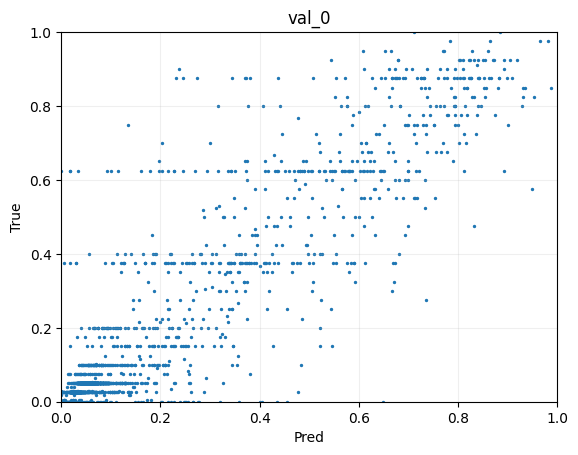

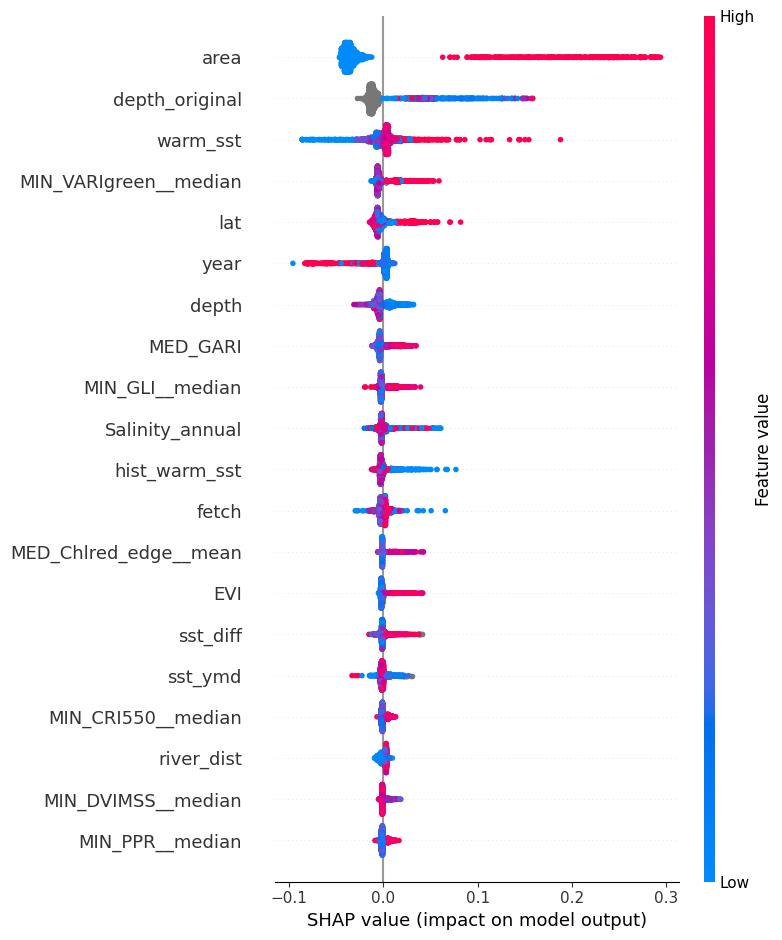

##############################
● CV1
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00370802
[1000]	valid_0's fair: 0.00342107
[1500]	valid_0's fair: 0.00325364
[2000]	valid_0's fair: 0.00312834
[2500]	valid_0's fair: 0.00304492
[3000]	valid_0's fair: 0.00298821
[3500]	valid_0's fair: 0.00294048
[4000]	valid_0's fair: 0.00290491
[4500]	valid_0's fair: 0.00288317
[5000]	valid_0's fair: 0.00286685
[5500]	valid_0's fair: 0.00284954
[6000]	valid_0's fair: 0.0028354
[6500]	valid_0's fair: 0.00282498
[7000]	valid_0's fair: 0.00281703
[7500]	valid_0's fair: 0.00280918
[8000]	valid_0's fair: 0.00280235
[8500]	valid_0's fair: 0.00279514
[9000]	valid_0's fair: 0.00279205
Early stopping, best iteration is:
[9217]	valid_0's fair: 0.00279056
0.17079966816021466


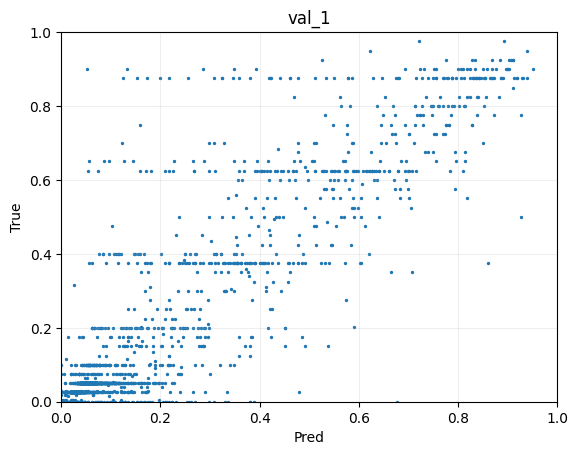

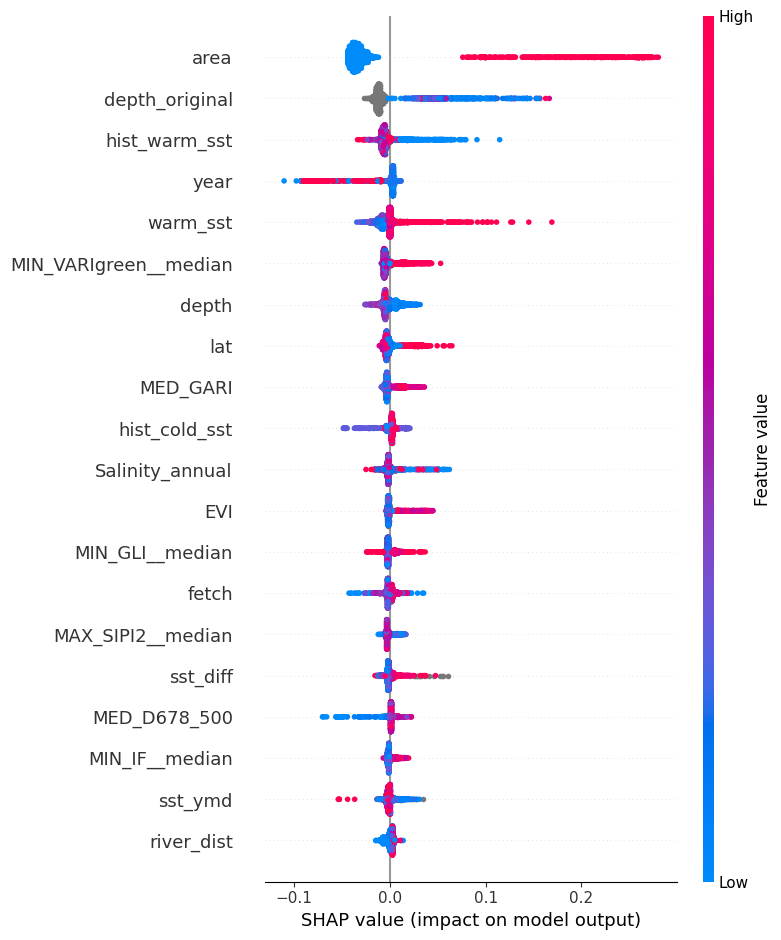

##############################
● CV2
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00341746
[1000]	valid_0's fair: 0.00312566
[1500]	valid_0's fair: 0.0029941
[2000]	valid_0's fair: 0.00291454
[2500]	valid_0's fair: 0.00286261
[3000]	valid_0's fair: 0.00281964
[3500]	valid_0's fair: 0.00278551
[4000]	valid_0's fair: 0.00275906
[4500]	valid_0's fair: 0.00273913
[5000]	valid_0's fair: 0.00272584
[5500]	valid_0's fair: 0.0027168
[6000]	valid_0's fair: 0.00270745
[6500]	valid_0's fair: 0.00269852
[7000]	valid_0's fair: 0.00269166
[7500]	valid_0's fair: 0.00268835
[8000]	valid_0's fair: 0.00268211
[8500]	valid_0's fair: 0.00267754
[9000]	valid_0's fair: 0.00267274
Early stopping, best iteration is:
[9041]	valid_0's fair: 0.00267244
0.17003401664993834


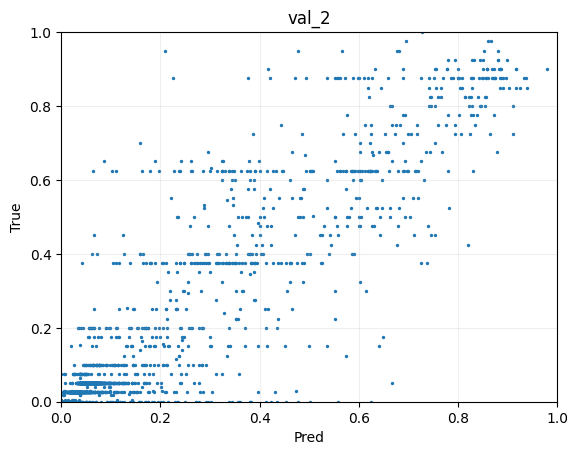

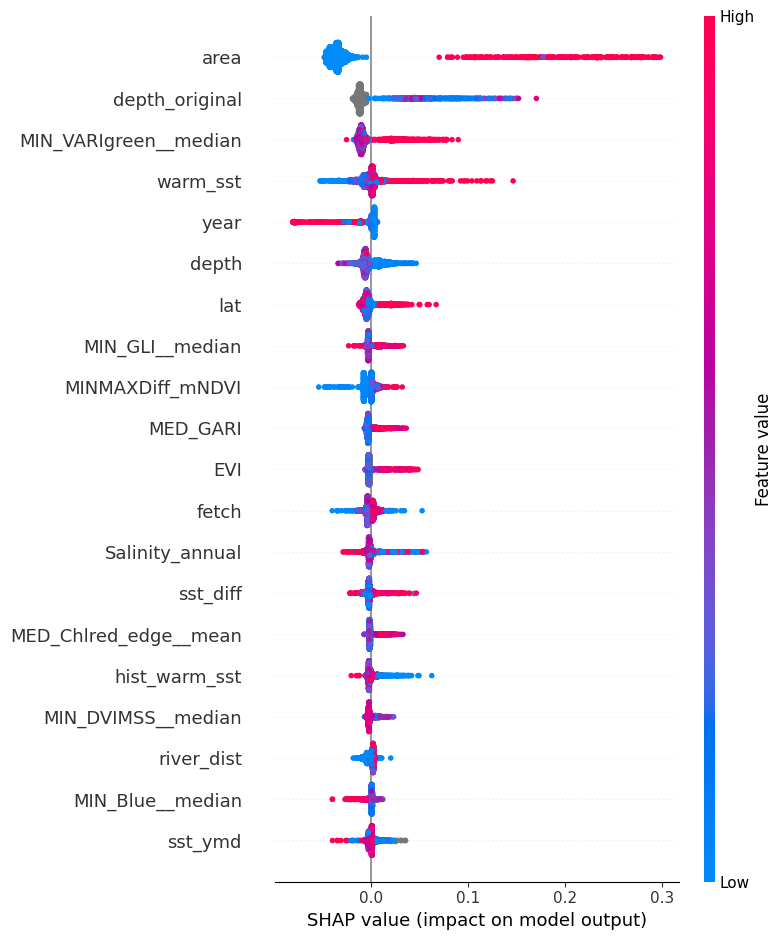

##############################
● CV3
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00319255
[1000]	valid_0's fair: 0.00290108
[1500]	valid_0's fair: 0.00275416
[2000]	valid_0's fair: 0.00266381
[2500]	valid_0's fair: 0.00261118
[3000]	valid_0's fair: 0.00256944
[3500]	valid_0's fair: 0.00253998
[4000]	valid_0's fair: 0.00251441
[4500]	valid_0's fair: 0.00249903
[5000]	valid_0's fair: 0.00248832
[5500]	valid_0's fair: 0.00247857
[6000]	valid_0's fair: 0.00246965
[6500]	valid_0's fair: 0.00245785
Early stopping, best iteration is:
[6792]	valid_0's fair: 0.00245569
0.16617333802835724


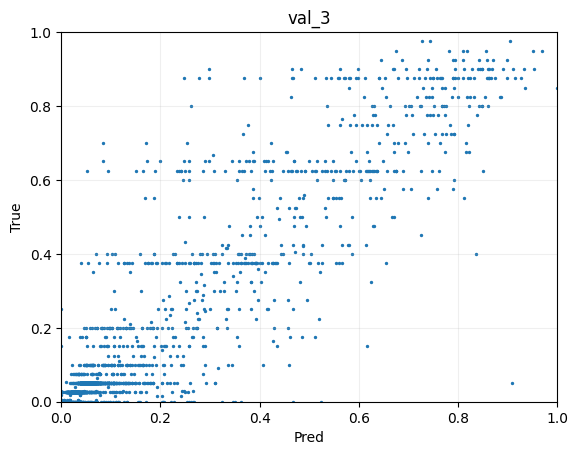

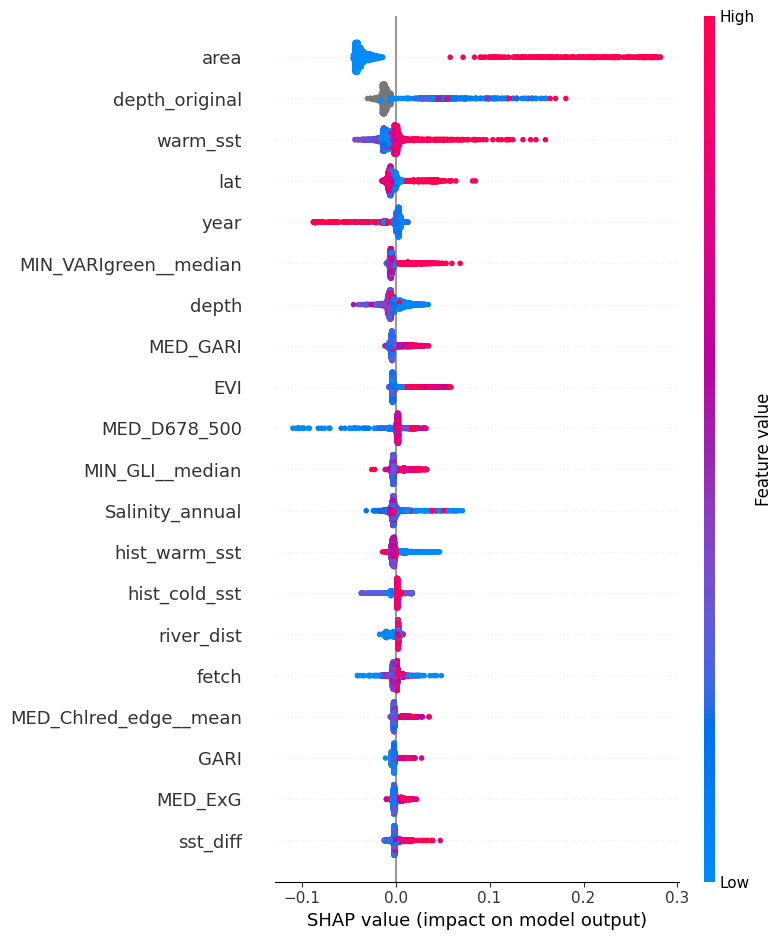

##############################
● CV4
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00318121
[1000]	valid_0's fair: 0.00296444
[1500]	valid_0's fair: 0.00284601
[2000]	valid_0's fair: 0.00276505
[2500]	valid_0's fair: 0.00273027
[3000]	valid_0's fair: 0.0026953
[3500]	valid_0's fair: 0.0026739
[4000]	valid_0's fair: 0.00265909
[4500]	valid_0's fair: 0.00264483
[5000]	valid_0's fair: 0.00263172
[5500]	valid_0's fair: 0.00262272
[6000]	valid_0's fair: 0.00261629
[6500]	valid_0's fair: 0.00260908
Early stopping, best iteration is:
[6464]	valid_0's fair: 0.00260863
0.16581231665168925


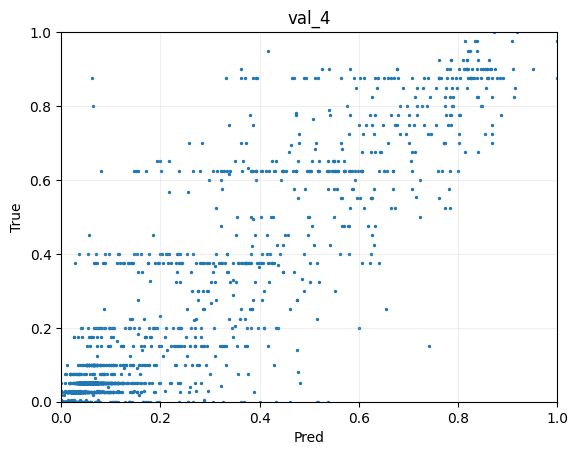

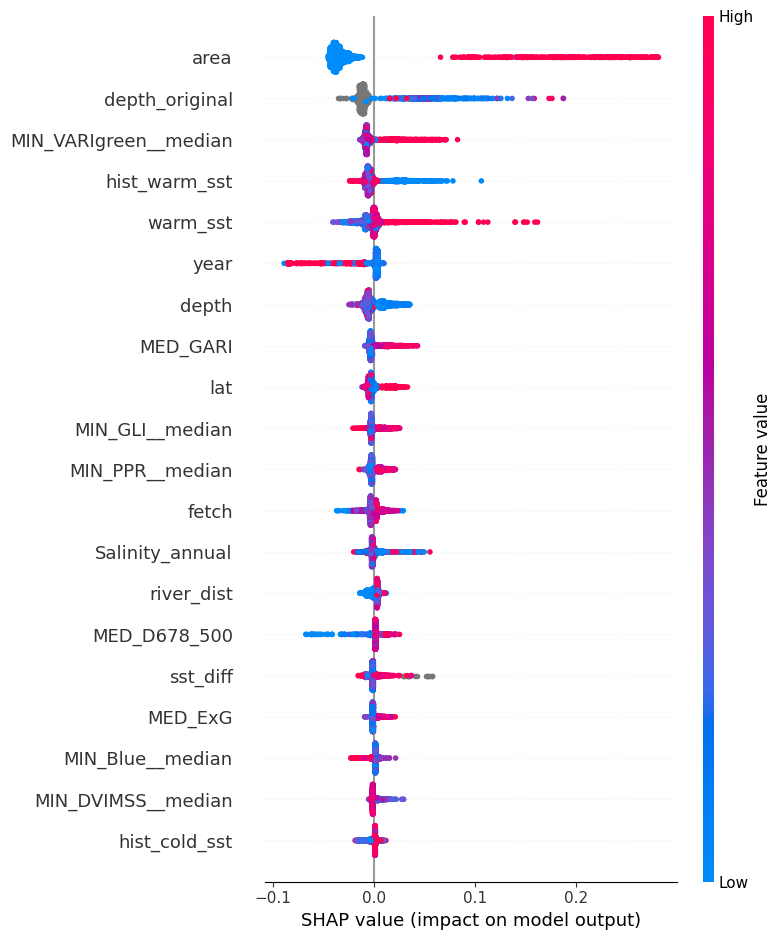

##############################
学習曲線
##############################


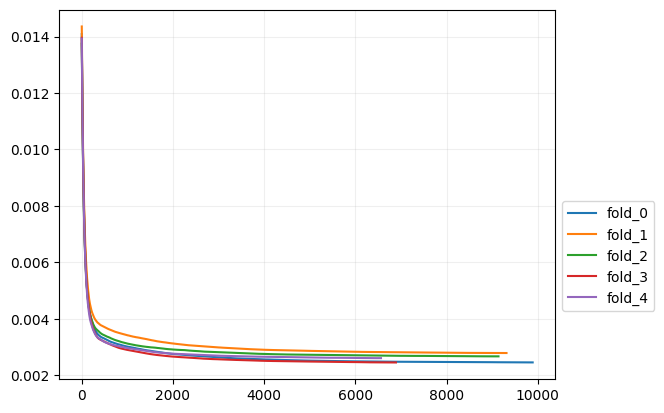

In [40]:
params = {
    'objective': 'fair',
    'metric': 'fair',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'n_estimators': 15000,
    'learning_rate': 0.01,
    # 'num_leaves': 50,
    # 'colsample_bytree': 0.6,
    # 'subsample': 0.5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

results_rmse, fi_df, y_test_pred = my_cross_val_predict(train, test, y_name="log_cover", y_raw_name="cover", params=params, features=features)

CV0: 0.103
CV1: 0.111
CV2: 0.105
CV3: 0.103
CV4: 0.105
Average: 0.105


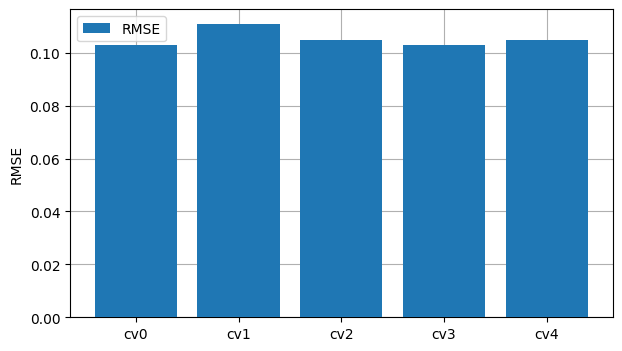

In [41]:
for i, rmse in enumerate(results_rmse):
    print(f"CV{i}: {rmse:.3f}")
print(f"Average: {np.average(results_rmse):.3f}")
plot_results(results_rmse)

(5, 391)


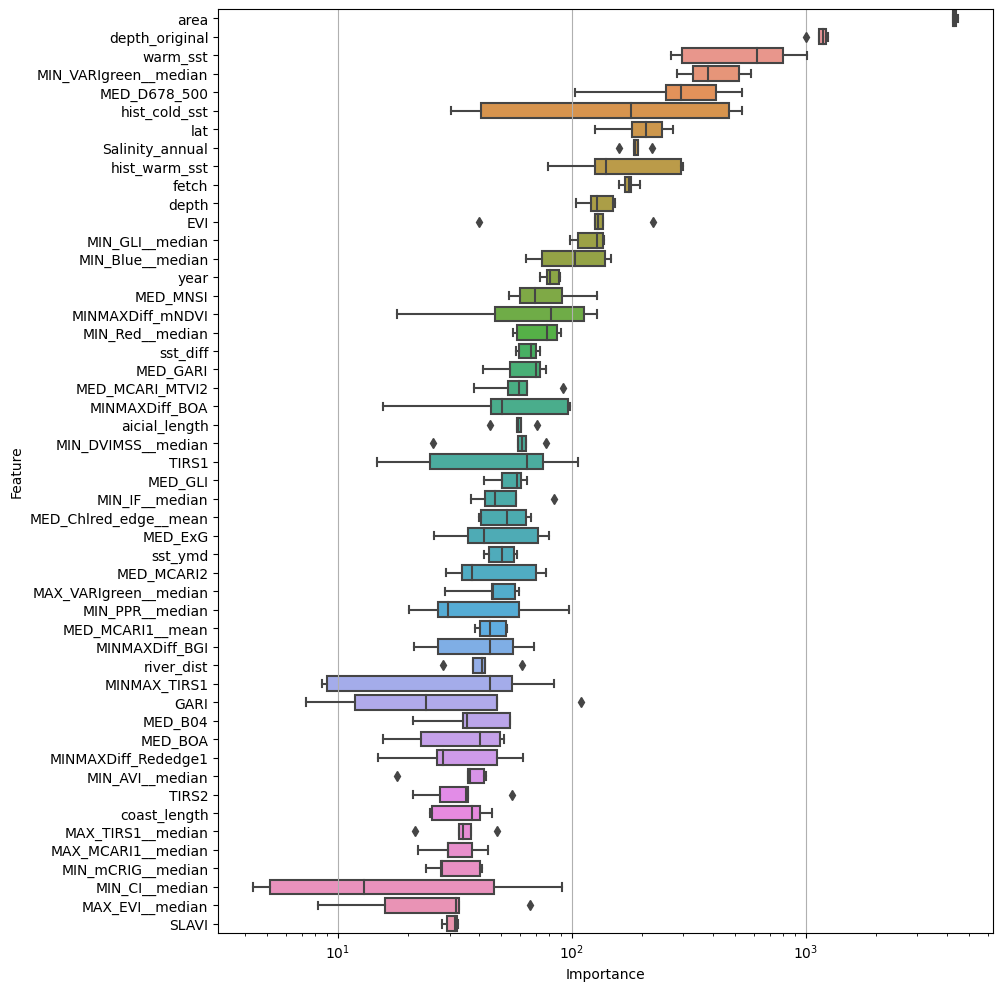

In [42]:
plot_importance(fi_df, figsize=(10, 12))

# Sub作成

In [43]:
test_sub = pd.DataFrame(y_test_pred, columns=["pred"])
test_sub

,pred
0,0.055851
1,0.054750
2,0.568161
3,0.044292
4,0.162513
...,...
4034,0.097858
4035,0.037087
4036,0.611764
4037,0.063850


In [44]:
test_pred_mean = test_sub["pred"].mean()
test_pred_mean

0.18786962750013364

In [45]:
test_sub2 = test_sub.copy()
public_mean = 0.09088
# test_sub["pred"] = test_sub["pred"] * (public_mean / test_pred_mean)
test_sub2["pred"] -= (test_pred_mean - public_mean)
test_sub2["pred"] = np.clip(test_sub2["pred"].values, 0, 1)
test_sub2

,pred
0,0.000000
1,0.000000
2,0.471171
3,0.000000
4,0.065523
...,...
4034,0.000869
4035,0.000000
4036,0.514775
4037,0.000000


In [46]:
print("pred_最小値:", test_sub["pred"].min())
print("pred_最大値:", test_sub["pred"].max())
print("pred_平均値:", test_sub["pred"].mean())

pred_最小値: 0.0
pred_最大値: 0.8742087769758703
pred_平均値: 0.18786962750013364


In [47]:
print("●後処理後")
print("pred_最小値:", test_sub2["pred"].min())
print("pred_最大値:", test_sub2["pred"].max())
print("pred_平均値:", test_sub2["pred"].mean())

●後処理後
pred_最小値: 0.0
pred_最大値: 0.7772191494757367
pred_平均値: 0.11074295322932433


In [48]:
if SAVE_SUB:
    test_sub.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}.csv", header=False)
    test_sub2.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}_mod.csv", header=False)

In [49]:
df_nullCount_train = pd.DataFrame(columns=["nullCount_train"])
for feat in features:
    df_nullCount_train.loc[feat, "nullCount_train"] = train[feat].isnull().sum()
df_nullCount_train.sort_values(by="nullCount_train", inplace=True, ascending=False)
df_nullCount_train.head(30)

,nullCount_train
depth_original,9717
GEMI,3414
EVI,3414
NormR,3414
Chlred_edge,3414
SIPI2,3414
NormG,3414
mCRIRE,3414
MINMAX_GEMI,3414
MINMAX_DSWI_5,3414
